<h1>SVM Regression</h1>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold, GridSearchCV, LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Machine learning/data/final_spotify_tracks.csv')
data.set_index('title', inplace=True)
data.head()

,artist,top genre,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",Train,POP,3.693075,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83
Love The Way You Lie,Eminem,HIPHOP,44.814807,94.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82
TiK ToK,Kesha,POP,6.410236,81.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80
Bad Romance,Lady Gaga,POP,17.680180,89.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79
Just the Way You Are,Bruno Mars,POP,31.020064,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78


In [ ]:
genres = data['top genre']

Since svm uses Euclidean distance, it is not suitable with the categorical variables we have. I am only going to use the continuous variables.

In [ ]:
data.drop(['artist', 'top genre', 'year'], axis=1, inplace=True)

In [ ]:
labels = ['track_popularity']
features = data.columns.drop(labels)
X = data[features]
Y = data[labels]

In [ ]:
X = X.fillna(X.median())

Filling the missing values with the median since the attributes have skewed distributions.

Standardizing the data to lower the effect on the decision boundry.

In [ ]:
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])

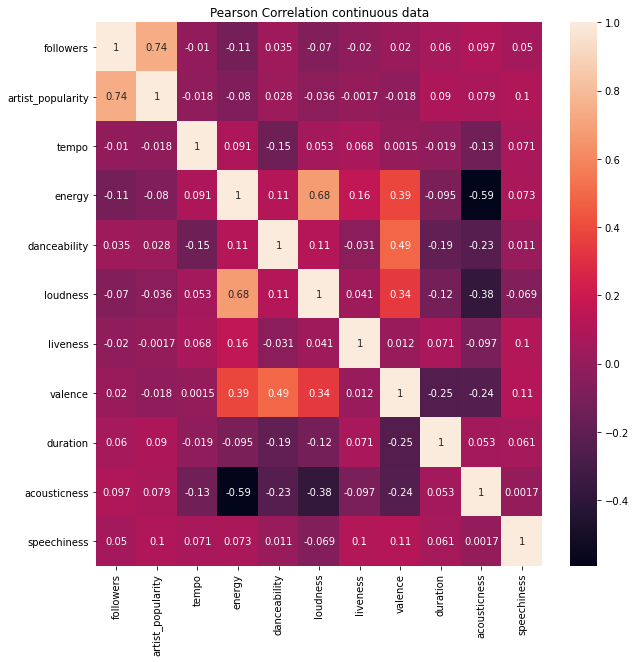

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(X.corr(), annot=True)
plt.title('Pearson Correlation continuous data')
plt.show()

Not many high correlations. Significant correlatio between artist_popularity and followers, and between energy and loudness, and energy and acousticness.

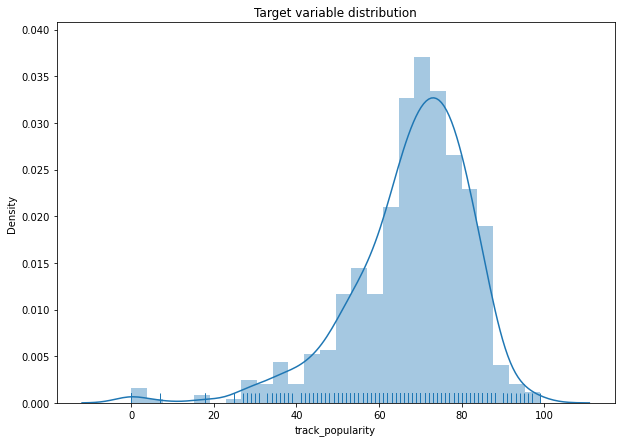

In [ ]:
plt.figure(figsize=(10,7))
sns.distplot(data['track_popularity'], kde=True, rug=True)
plt.title('Target variable distribution')
plt.show()

We have a skewed target variable.

Define a function for leave one out cross validation for regression.

In [ ]:
def cross_validation_regression(X, Y, model): 
  predicted = []
  actual = []
  folds = LeaveOneOut()

  for train_ind, test_ind in folds.split(X):
    X_train = X.iloc[train_ind]
    Y_train = Y.iloc[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y.iloc[test_ind]
    model.fit(X_train, Y_train)
    predicted_vals = model.predict(X_test)
    predicted.extend(predicted_vals)
    actual.extend(list(Y_test.values))

  return predicted, actual

Draw the predicted agains the actual values of the target, sorted by the error in increasing order.

In [ ]:
def draw_error_distribution(errors, predictions, actual):
  ordered_values = []
  for i in range(len(errors)):
    node = {}
    node['predicted'] = predictions[i]
    node['actual'] = actual[i]
    node['error'] = errors[i]
    ordered_values.append(node)
  ordered_values.sort(key = lambda item: item['error'])
  x = np.arange(1, len(errors) + 1)
  plt.figure(figsize=(40, 15))
  for i, elem in enumerate(ordered_values):
    plt.bar(x[i]-0.5, elem['actual'], width=0.5, color='orange', align='center', label='True values')
    plt.bar(x[i], elem['predicted'], color='blue', label='Predicted values', width = 0.5, align='center')
  plt.legend(['Actual', 'Predicted'])
  plt.title('Predictions vs Actual values')

Define a function for hyper parameter searching using inner 5-fold cross validation and optimizing mean absolute error.

In [ ]:
def hyper_parameter_search(X, Y, params, kernel = 'rbf'):
  svm = SVR(kernel=kernel)
  gscv = GridSearchCV(svm, params, n_jobs=-1, scoring='neg_mean_absolute_error', cv=5)
  svm_best = gscv.fit(X = X, y=Y)
  return svm_best.best_params_, svm_best.best_score_

In [ ]:
PARAMS = {
    'C' : [1.3, 1.5, 3, 10, 15],
    'epsilon': [0.05, 0.01, 0.003]
}

Define the parameters for grid search, C-regularization term, epsilon - if epsilon = 0 we have hard assignment, if it is bigger than zero, some points can be wrongly predicted.

<h3>SVM RBF Kernel</h3>

In [ ]:
svm_params, svm_score = hyper_parameter_search(X, Y, PARAMS, 'rbf')

I am performing grid search for the parameters using Radial basis function kernel in the svm.

In [ ]:
print(f'params: {svm_params}, score: {-svm_score}')

params: {'C': 3, 'epsilon': 0.01}, score: 10.540492777373238


In [ ]:
svm = SVR(kernel='rbf', C = svm_params['C'], epsilon=svm_params['epsilon'])

In [ ]:
svm_preds, svm_act = cross_validation_regression(X, Y, svm)

In [ ]:
print(f'----------------------')
print(f'Scores: ')
print(f'----------------------')
print(f'MSE: {mean_squared_error(svm_act, svm_preds)}')
print(f'MAE: {mean_absolute_error(svm_act, svm_preds)}')
print(f'R2 Score: {r2_score(svm_act, svm_preds)}')

----------------------
Scores: 
----------------------
MSE: 191.1296621555707
MAE: 9.86729576016101
R2 Score: 0.08214123714098831


These scores are similar to the single decision tree and basic linear regression, but are worse than the random forest.

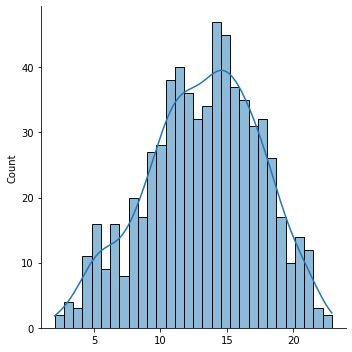

In [ ]:
sns.displot(np.subtract(svm_act,svm_preds)[0],bins=30, kde=True)
plt.show()

Almost normal distribution of errors, median at around 13, mean at around 15.

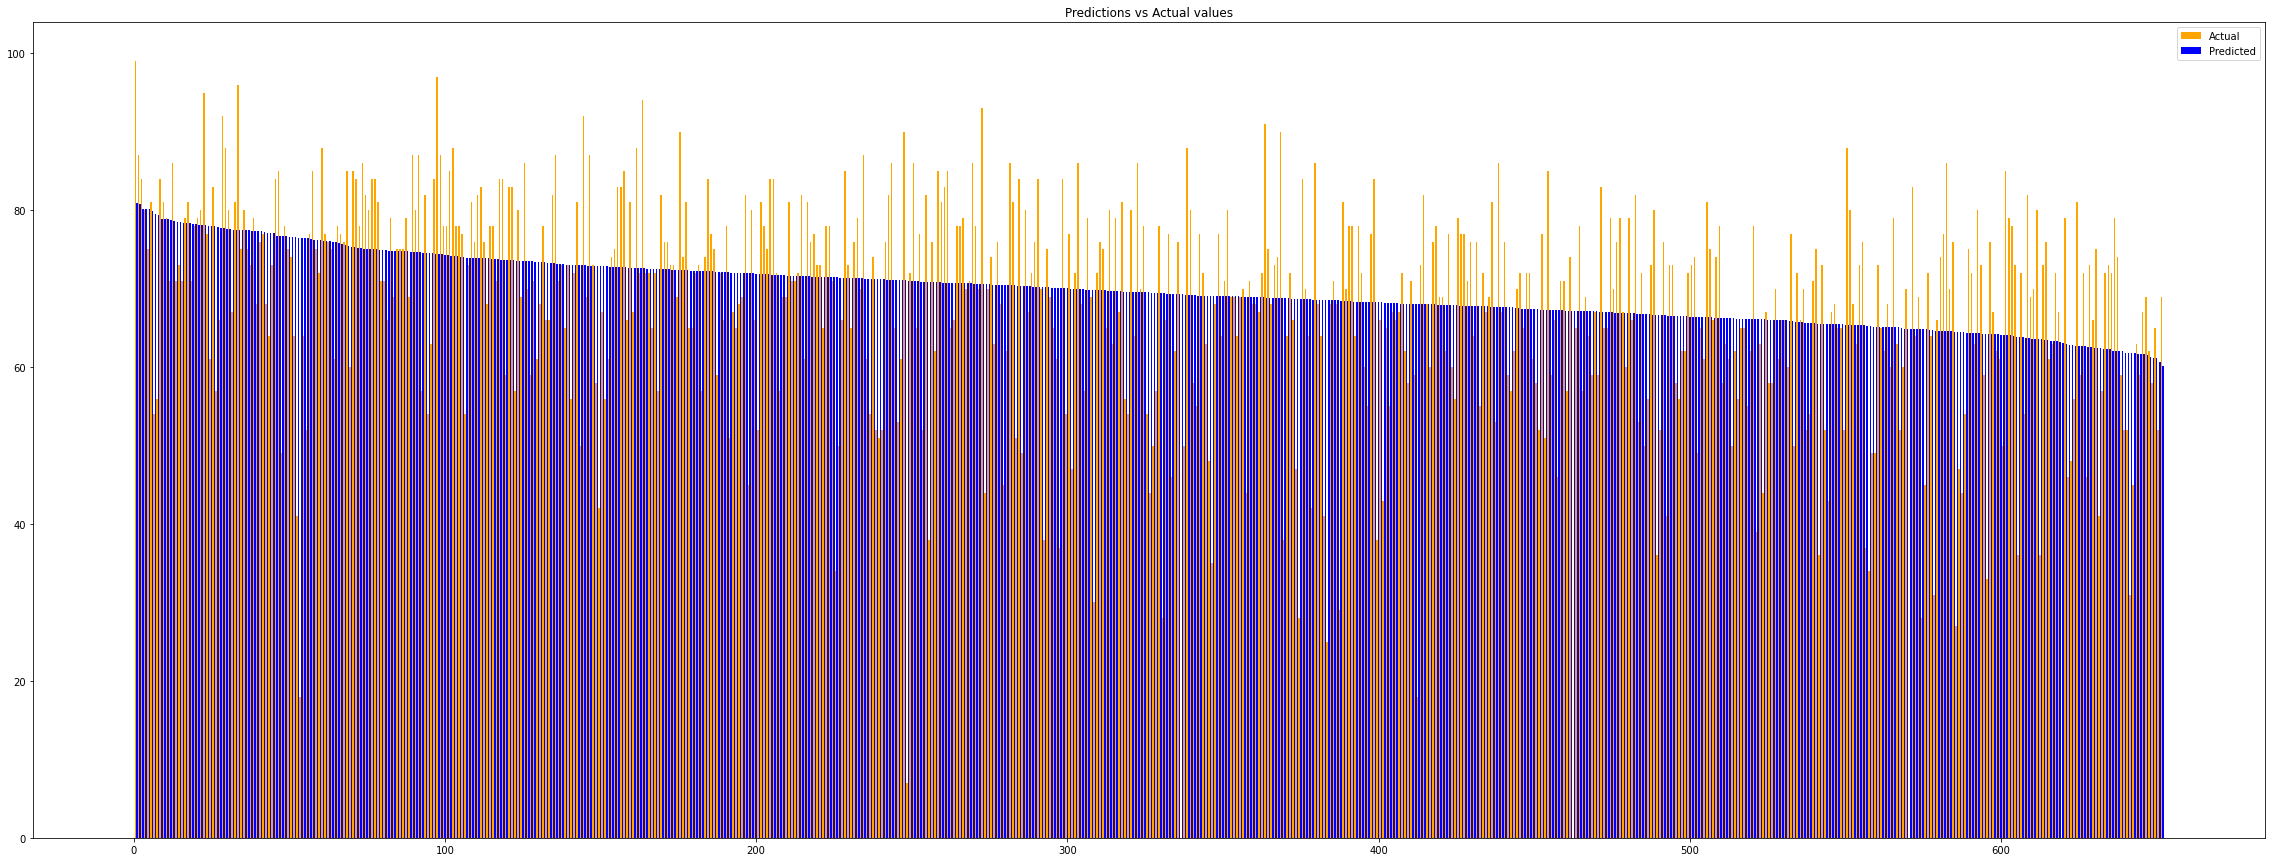

In [ ]:
draw_error_distribution(np.subtract(svm_act,svm_preds)[0], svm_preds, svm_act)

Almost constantly high predictions of the target. The svm does not model the data well.

<h3>SVM Linear Kernel</h3>

In [ ]:
svm_params, svm_score = hyper_parameter_search(X, Y, PARAMS, 'linear')

Now, let's do the same hyper parameter search but this time witha  liear instead of rbf kernel.

In [ ]:
print(f'params: {svm_params}, score: {-svm_score}')

params: {'C': 1.3, 'epsilon': 0.003}, score: 10.469716117262184


In [ ]:
svm = SVR(kernel='linear', C = svm_params['C'], epsilon=svm_params['epsilon'])

In [ ]:
svm_preds_linear, svm_act_linear = cross_validation_regression(X, Y, svm)

In [ ]:
print(f'----------------------')
print(f'Scores: ')
print(f'----------------------')
print(f'MSE: {mean_squared_error(svm_act_linear, svm_preds_linear)}')
print(f'MAE: {mean_absolute_error(svm_act_linear, svm_preds_linear)}')
print(f'R2 Score: {r2_score(svm_act_linear, svm_preds_linear)}')

----------------------
Scores: 
----------------------
MSE: 186.04508004701245
MAE: 9.740237501706662
R2 Score: 0.10655884030724982


The results with the linear kernel are better than with the rbf kernel in all metrics.

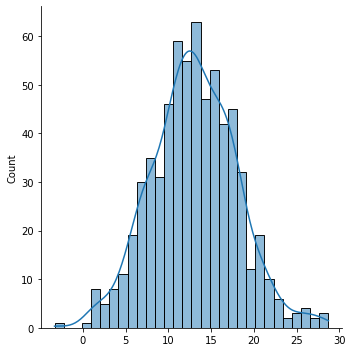

In [ ]:
sns.displot(np.subtract(svm_act_linear,svm_preds_linear)[0],bins=30, kde=True)
plt.show()

Normal distribution of errors with mean at around 13. A bit better than with rbf kernel, but still not satisfactory. We want the error to be close to 0.

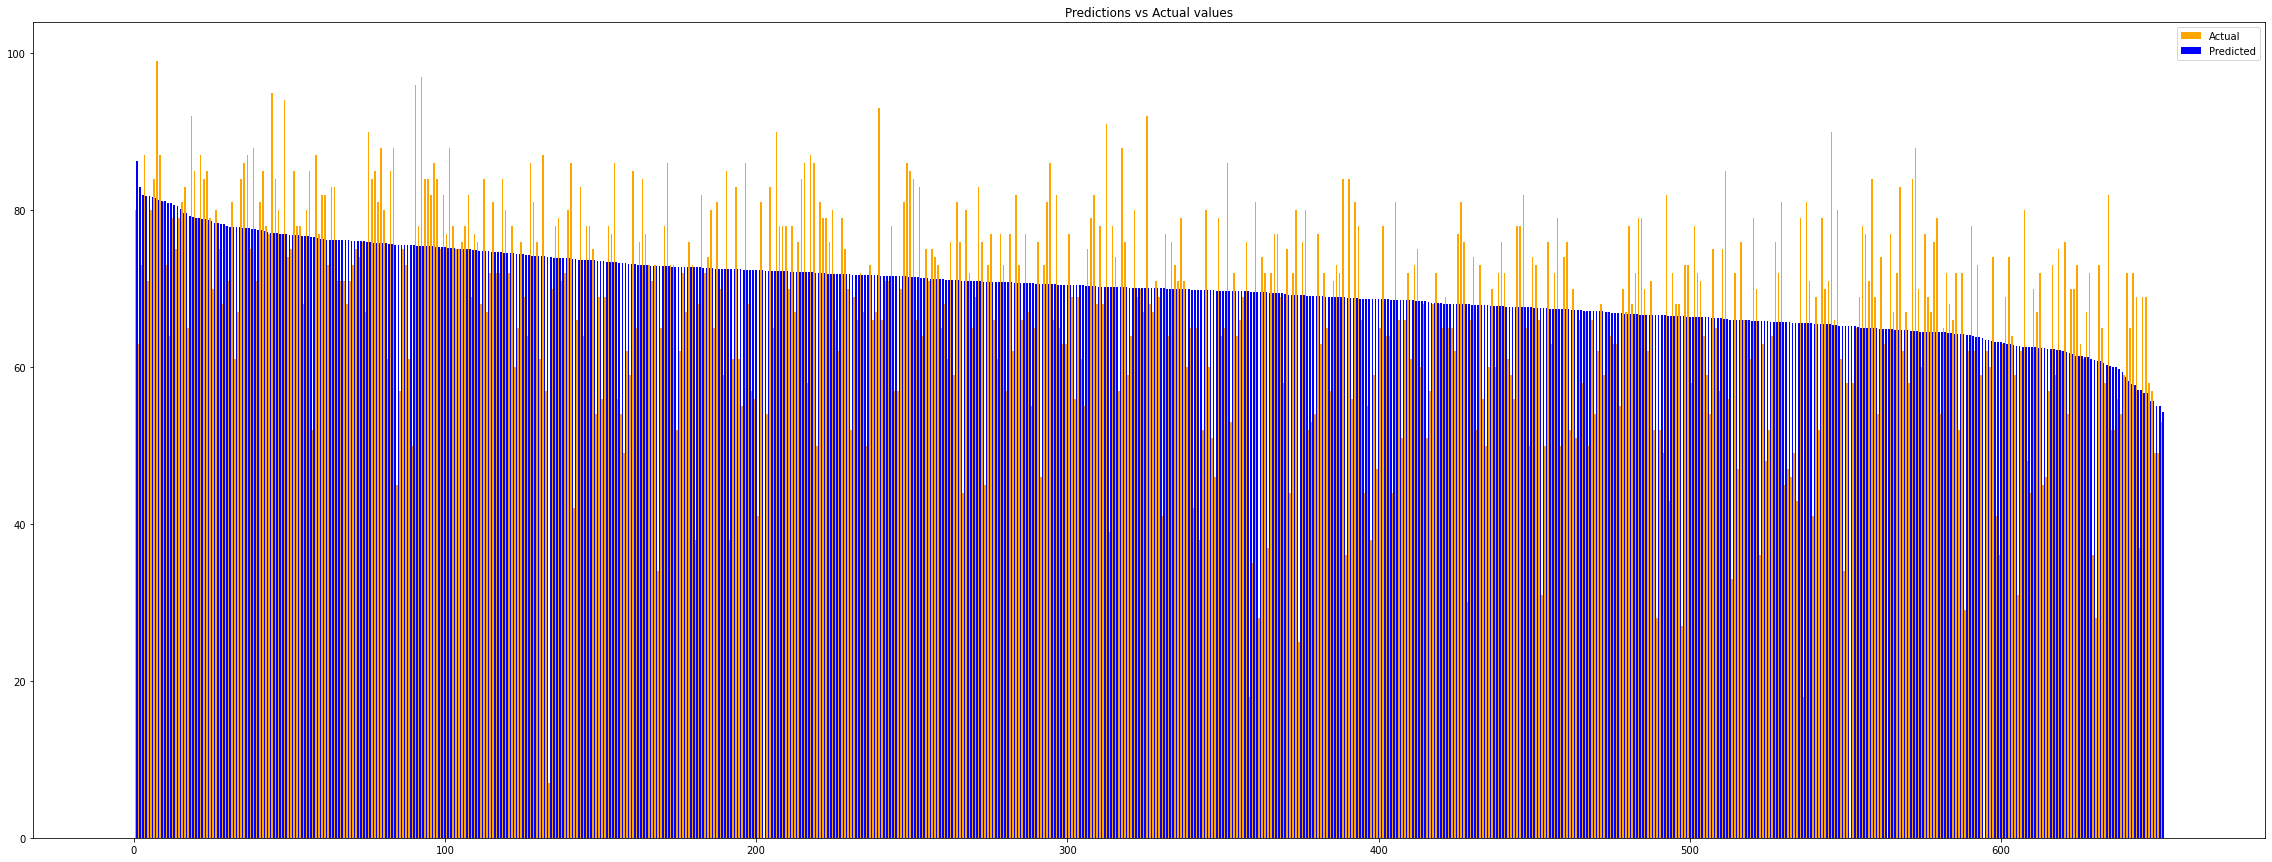

In [ ]:
draw_error_distribution(np.subtract(svm_act_linear,svm_preds_linear)[0], svm_preds_linear, svm_act_linear)

Almost constant distribution of errors. Overshoots too often. Does not model the target well.

<h3>SVM Polynomial Kernel</h3>

In [ ]:
svm_params, svm_score = hyper_parameter_search(X, Y, PARAMS, 'poly')

Perform the same grid search but now with a polynomail kernel with 2 degrees.

In [ ]:
print(f'params: {svm_params}, score: {-svm_score}')

params: {'C': 1.3, 'epsilon': 0.05}, score: 10.419936135914247


In [ ]:
svm = SVR(kernel='poly', C = svm_params['C'], epsilon=svm_params['epsilon'])

In [ ]:
svm_preds_poly, svm_act_poly = cross_validation_regression(X, Y, svm)

In [ ]:
print(f'----------------------')
print(f'Scores: ')
print(f'----------------------')
print(f'MSE: {mean_squared_error(svm_act_poly,svm_preds_poly)}')
print(f'MAE: {mean_absolute_error(svm_act_poly, svm_preds_poly)}')
print(f'R2 Score: {r2_score(svm_act_poly, svm_preds_poly)}')

----------------------
Scores: 
----------------------
MSE: 198.63631840362203
MAE: 10.12166648839419
R2 Score: 0.04609214806011053


The results with polynomial kernel are worse than with linear and rbf kernel.

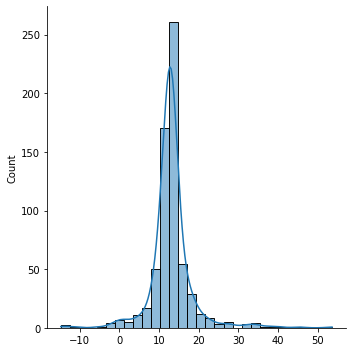

In [ ]:
sns.displot(np.subtract(svm_act_poly,svm_preds_poly)[0],bins=30, kde=True)
plt.show()

Normal distribution wiht mean at around 15.

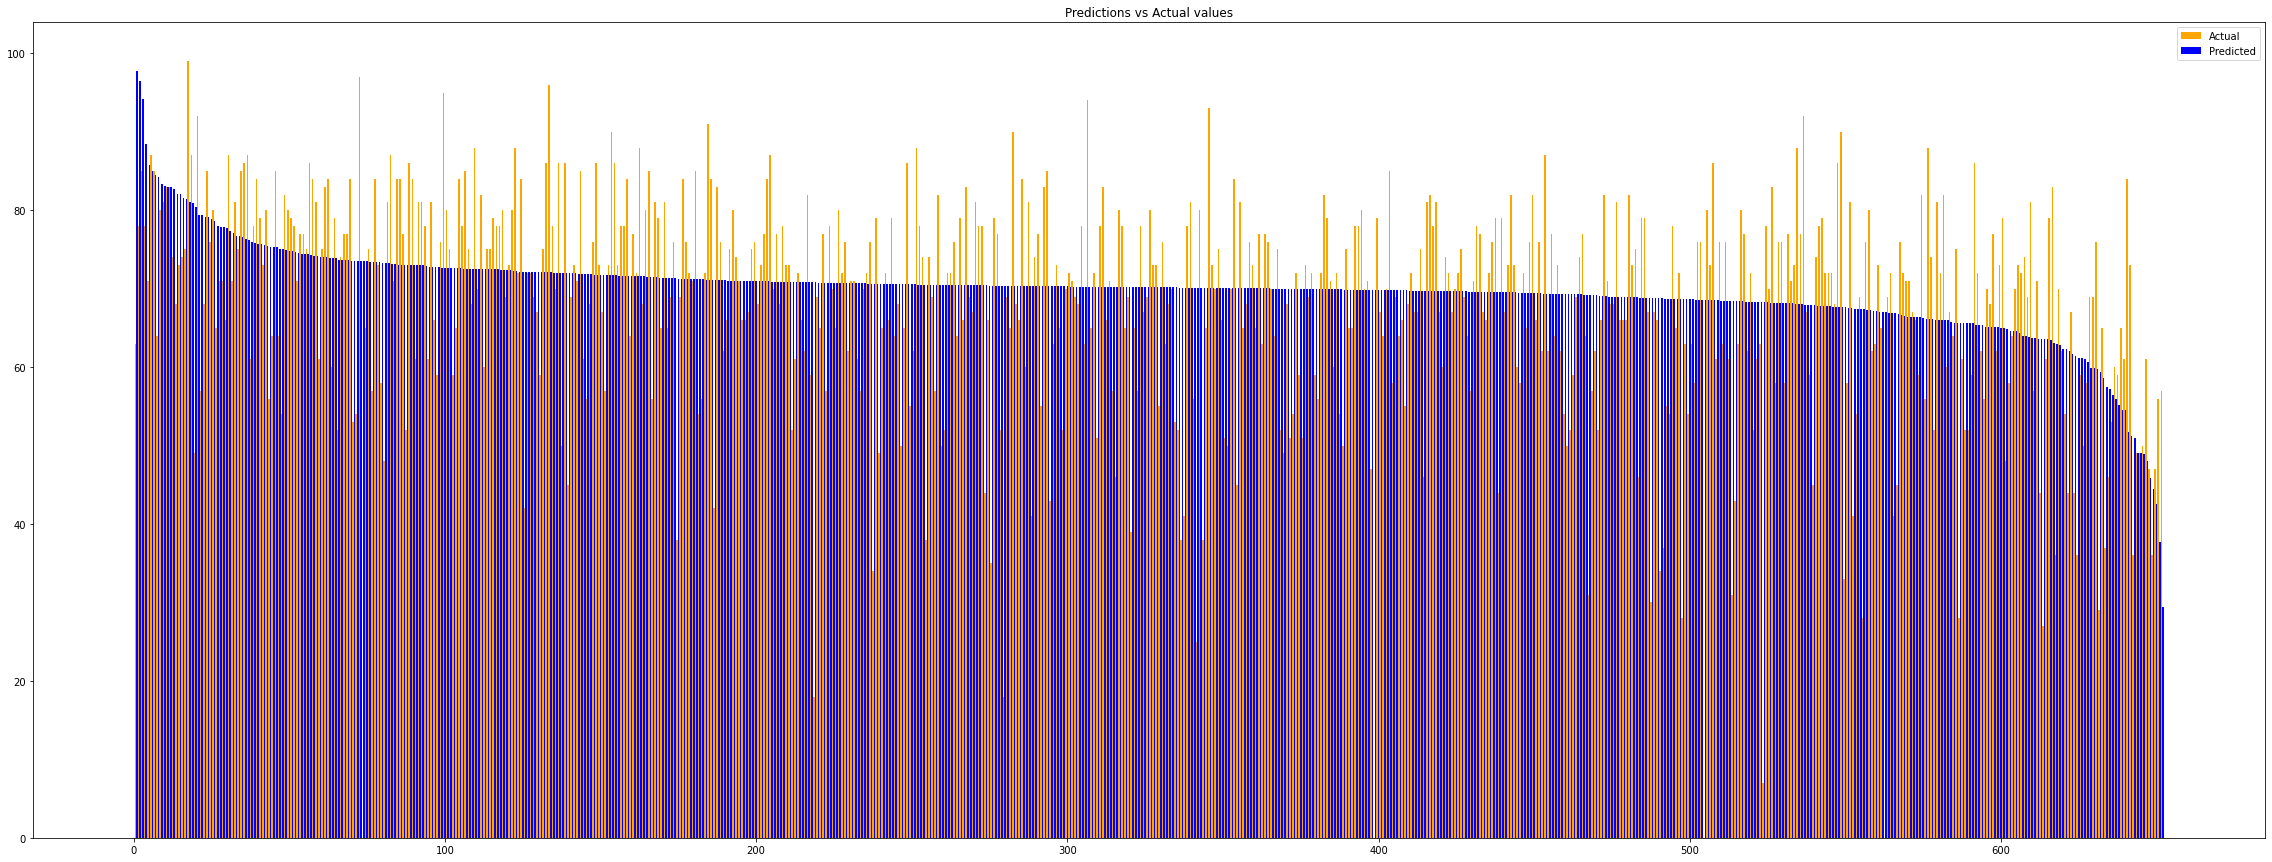

In [ ]:
draw_error_distribution(np.subtract(svm_act_poly,svm_preds_poly)[0], svm_preds_poly, svm_act_poly)

Almost same as previous svm models. We can see that svm cannot model this relationship with any kernel function.

<b>Since neither linear regression (including lasso and ridge) nor svm can model the target well, the assumption is that the relationship is nonlinear in the original and abstract feature spaces.</b>